In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import glob
from itertools import chain
import os
import random
import zipfile
plt.style.use("ggplot")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT
import seaborn as sns   #←これを追加
import timm    #←これを追加
from albumentations.core.transforms_interface import DualTransform

from efficientnet_pytorch import EfficientNet

from albumentations.core.transforms_interface import ImageOnlyTransform
from albumentations.augmentations import functional as F
from PIL import Image, ImageOps, ImageEnhance

In [2]:
class CFG:

                       # No. of epochs for training the model
  # Training settings
  batch_size = 25
  epochs = 20
  lr = 3e-5
  gamma = 0.7
  seed = 42                      # Batch Size for Dataset

#   model_name = 'tf_efficientnet_b4_ns'    # Model name (we are going to import model from timm)
  IMG=224
  img_size = (IMG,IMG)                        # Resize all the images to be 224 by 224
  
  # going to be used for loading dataset
  ds_path = "/root/meidai/data/imgB/ABC20220706-1"




# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device on which we are:{}".format(device))

device on which we are:cuda


In [3]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(CFG.seed)


In [4]:
from pathlib import Path
labels = []
Base_dir=[]
import os
        

for category in ['A','B','C']:
    for p in os.listdir(os.path.join(CFG.ds_path, category)):
        f = Path(os.path.join(CFG.ds_path,category, p))
        Base_dir.append(str(f))
        labels.append(str(f.parent.stem))

In [5]:
class Dataset():
    def __init__(self, filelist, transform = None):
        self.filelist = filelist
        self.transform = transform

    def __len__(self):
        return int(len(self.filelist))

    def __getitem__(self, index):
        imgpath = self.filelist[index]
        img = Image.open(imgpath).convert(mode="RGB")

        if "A" in imgpath[-20:]:
            label = 0
        elif "B" in imgpath[-20:]:
            label = 1
        elif "C" in imgpath[-20:]:
            label=2

        if self.transform is not None:
            img = self.transform(img)

        return (img, label)

In [6]:
train_dir, test_dir = train_test_split(Base_dir, test_size=0.2,random_state=123,stratify=labels)

In [7]:
import albumentations

In [8]:
test_transformer= transforms.Compose([
    transforms.Resize(CFG.img_size),
    transforms.ToTensor(),
])

In [9]:
test=Dataset(test_dir,test_transformer)

In [10]:

from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_base_patch16_224_in22k',
 'beitv2_large_patch16_224',
 'beitv2_large_patch16_224_in22k',
 'botnet26t_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'coatnet_0_rw_224',
 'coatnet_1_rw_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_rw_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_atto',
 'convnext_atto_

In [11]:
model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=3)
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    

In [12]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=CFG.gamma)

In [13]:
import time
from tqdm import tqdm
import time
import copy

In [14]:
training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}

In [15]:
classes=['A','B','C']

In [16]:
vit_models=[]
for i in range(5):
    model.load_state_dict(torch.load(f'./weights/model_5e_{i}.pth'))
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    vit_models.append(model)

In [19]:
import cv2
import timm
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms

from PIL import Image
from gradcam.utils import visualize_cam
class VitAttention:
    def  __init__(self,vit_models) -> None:
        self.model = vit_models[0]
        self.model.to(device)
        self.model.eval()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
        self.transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), self.normalize,])
        self.invTrans = transforms.Compose([ transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]),])
    # Attention Weightを取得するための関数 
    def extract(self,pre_model, target, inputs):
        feature = None
        def forward_hook(module, inputs, outputs):
            # 順伝搬の出力を features というグローバル変数に記録する 
            global blocks
            blocks = outputs.detach()
        # コールバック関数を登録する
        handle = target.register_forward_hook(forward_hook) # 推論する
        pre_model.eval()
        pre_model(inputs)
        # コールバック関数を解除する
        handle.remove()
        return blocks
    
    def forward_hook(self,module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する 
        global blocks
        blocks = outputs.detach()
    def attention(self,file_dir):
        # blockごと(Transformer Encoderのlayer)のAttention Weightを取得 # L:層数, H:ヘッド数、N:パッチ数+クラストークン 
        attention_weight = []
        # 画像をリサイズしてセンタークロップ


        # 画像ファイルを読み込み
        #image = Image.open('/path/to/image')
        image = Image.open(file_dir).convert(mode="RGB")

        x = self.transform(image) # shape :(3, 224, 224)
        x = x.view(1, *x.shape) # shape :(1, 3, 224, 224)
        for i in range(len(self.model.blocks)):
            target_module = self.model.blocks[i].attn.attn_drop
            features = self.extract(self.model, target_module, x.to(device)) # shape: (1, H, N, N)
            attention_weight.append([features.to('cpu').detach().numpy().copy()])
        attention_weight = np.squeeze(np.concatenate(attention_weight), axis=1) # shape: (L, H, N, N)

        # ヘッド方向に平均
        mean_head = np.mean(attention_weight, axis=1) # shape: (L, N, N)
        # NxNの単位行列を加算
        mean_head = mean_head + np.eye(mean_head.shape[1])
        # 正規化
        mean_head = mean_head / mean_head.sum(axis=(1, 2))[:, np.newaxis, np.newaxis] # 層方向に乗算
        v = mean_head[-1]
        for n in range(1, len(mean_head)):
            v = np.matmul(v, mean_head[-1 - n])
        # クラストークンと各パッチトークン間とのAttention Weightから、
        # 入力画像サイズまで正規化しながらリサイズしてAttention Mapを生成
        mask = v[0, 1:].reshape(14, 14)
        attention_map = cv2.resize(mask / mask.max(), (x.shape[2], x.shape[3]))[..., np.newaxis]

        # 入力画像を正規化前に戻す
        inv_tensor = self.invTrans(x)[0]
        # Attention MapとAttentionをかけた画像を生成
        mask = torch.from_numpy(attention_map.astype(np.float32))
        _, result = visualize_cam(mask, inv_tensor.to(device))

        tmp=result.detach().cpu().numpy().transpose(1, 2, 0)
        img_pil = Image.fromarray((tmp*255).astype(np.uint8))
        dir_path='./attention_images2/'+file_dir[37]
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        img_pil.save(dir_path+file_dir[38:])
        # plt.savefig(dir_path+file_dir[38:-4]+'.png')
        # plt.imshow(result.detach().cpu().numpy().transpose(1, 2, 0))
        # plt.clf()

    def main(self,dirs):
        for image in dirs:
            self.attention(image)

In [20]:
att=VitAttention(vit_models)

In [21]:
att.main(test_dir)

In [27]:
img = Image.open('./attention_images2/A/name_of_the_image.tif').convert(mode="RGB")
plt.imshow(img)

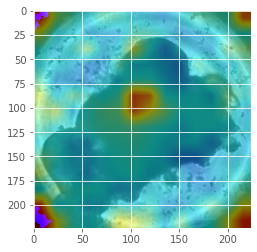

In [ ]:
import torch.nn.functional as F
class Grad_Cam:
    def __init__(self,model,list_of_dir=None) -> None:
        self.features = model.features.eval()
        self.pre= model.pre.eval()
        self.avgpool = model.pool_flatten.eval()
        self.classifier = model.head.eval()
        self.list_dir=list_of_dir

    def effv2_grad_cam(self,image_dir):
        image = cv2.imread(image_dir)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        input_image = test_transformer(image = image)["image"].float().unsqueeze(0).to(device)
        # 特徴マップを抽出する
        feature = self.features(input_image)
        # 特徴マップサイズ torch.Size([1, 512, 7, 7])
        # 上のteratailの回答を参照
        feature = feature.clone().detach().requires_grad_(True)
        # print('特徴マップサイズ', feature.size())
        # 特徴マップをVGG19の残りの全結合層に通して、予測結果を得る
        pres=self.pre(feature)
        pooled = self.avgpool(pres)
        y_pred = self.classifier(pooled.view(-1,1280))
        pred_index = torch.argmax(y_pred)
        # 予測結果に対して誤差逆伝播
        y_pred[0][pred_index].backward()
    
        # 特徴マップの勾配(feature.grad)のGlobal Average Poolingを計算する
        # つまり512枚の各特徴マップの要素の平均値を算出する（512次元のベクトルになる）
        # まずは7x7のそれぞれの特徴マップを１本のベクトルに変換
        feature_vec = feature.grad.view(256, 7*7) # feature_vec.size() = (512, 49)
        # 512本のそれぞれのベクトルの要素の平均を取る
        # 論文のαが計算される
        alpha = torch.mean(feature_vec, axis=1) # alpha.size() = (512)
        # print('alpha_size',alpha.shape,alpha)
        # batch_sizeの次元を削除
        # (1x256x7x7) -> (256x7x7)
        feature = feature.squeeze(0)
        # 論文のLを計算
        h=torch.max(torch.sum(feature*alpha.view(-1,1,1),0))
        if h>0:
            L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)).cpu()
        elif h<0:
            L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0)+h*(-2)).cpu()
        else:
            L = torch.sum(feature*alpha.view(-1,1,1),0).cpu()
        L = L.detach().numpy()
        # 0-1で正規化
        L_min = np.min(L)
        L_max = np.max(L - L_min)+0.00001
        L = (L - L_min)/L_max

        # 元画像と同じサイズにリサイズする
        L = cv2.resize(L, (224, 224))
        # heat map に変換
        
        img2 = self.toHeatmap(L)
        img1 = input_image.squeeze(0).permute(1,2,0).cpu()/255
        alpha = 0.5
        grad_cam_image = (img1*alpha + img2*(1-alpha))
        cat_tensor = torch.cat([grad_cam_image, img1], dim = 1)
        # print(grad_cam_image.shape)
        # plt.figure(figsize=(15, 15), dpi=50)
        # plt.imshow(cat_tensor)
        tmp = cat_tensor.to('cpu').detach().numpy().copy() 
        img_pil = Image.fromarray((tmp*255).astype(np.uint8))
        dir_path='./grad_cam_images2/'+image_dir[37]
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        #画像ファイルを出力して確認します
        img_pil.save(dir_path+image_dir[38:])
    def toHeatmap(self,x):
        x = (x*255).reshape(-1)
        cm = plt.get_cmap('jet')
        x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
        return x.reshape(224,224,3)
    def main(self):
        for i in range(len(self.list_dir)):
            self.effv2_grad_cam(self.list_dir[i])

